INFO:transformers.tokenization_utils:Model name './model_bert_crosloengual/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, bert-base-finnish-cased-v1, bert-base-finnish-uncased-v1, bert-base-dutch-cased). Assuming './model_bert_crosloengual/' is a path, a model identifier, or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file ./model_bert_crosloengual/added_tokens.json. We won't load it.
INFO:transformers.tokenization_utils:loading file ./model_bert_crosloengual/vocab.txt
INFO:transformers.token

feature 1/8
needed [1. 1. 1.] n 50
feature 2/8
needed [1. 1. 1.] n 50
feature 3/8
needed [1. 1. 1.] n 50
feature 4/8
needed [1. 3. 5.] n 50
feature 5/8
needed [1. 1. 1.] n 50
feature 6/8
needed [1. 1. 1.] n 50
feature 7/8
needed [1. 1. 1.] n 50
feature 8/8


100%|██████████| 1/1 [01:23<00:00, 83.14s/it]

needed [1. 1. 1.] n 50


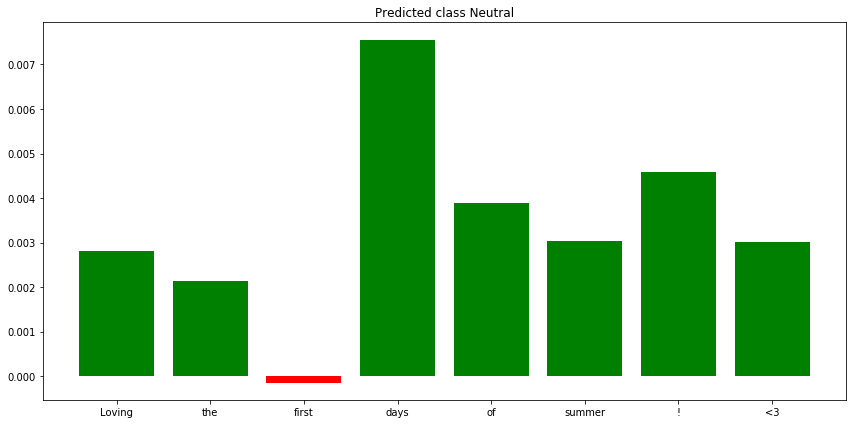

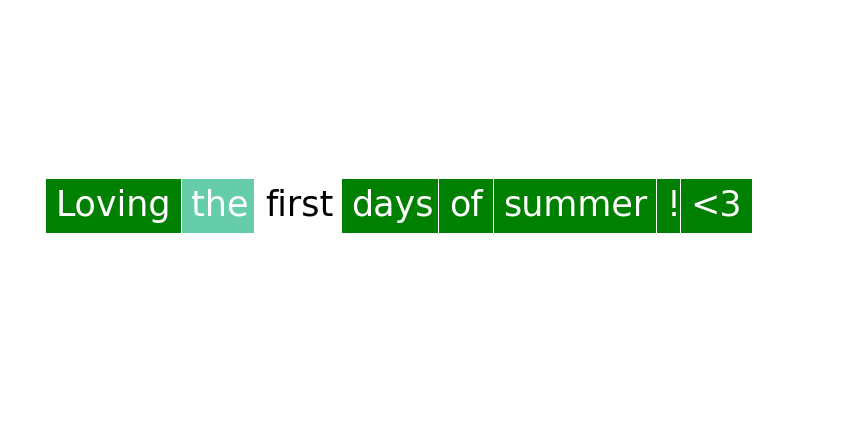

In [1]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import logging
logging.basicConfig(level=logging.INFO)
import pandas as pd
import visualize_explanations
from nltk.tokenize import TweetTokenizer
import IME_for_text

USE_GPU = 0
MAX_SEQ_LEN = 40 # poljubno do max 512
def word2tokens(word, tokenized):
    if word in tokenized:
        return [tokenized.index(word)]
    else:
        for t in range(len(tokenized)):
            if tokenized[t] in word and '##' in tokenized[t+1]:
                isword = tokenized[t]
                for j in range(t+1, len(tokenized)):
                    isword+=tokenized[j][2:]
                    if word == isword:
                        return([i for i in range(t,j+1)])
                        break

class SCForShap(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
    #@add_start_docstrings_to_callable(BERT_INPUTS_DOCSTRING)
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None,):
        output = super().forward(input_ids, attention_mask, token_type_ids, position_ids, head_mask, inputs_embeds, labels)
        return output[0]

# Device configuration
device = torch.device('cuda' if (torch.cuda.is_available() and USE_GPU) else 'cpu')

# Load pre-trained model tokenizer (vocabulary)
#pretrained_model = 'twitter_results/transformers_result_sl_shebert-f128'
pretrained_model = './model_bert_crosloengual/'
tokenizer = BertTokenizer.from_pretrained(pretrained_model, do_lower_case=False)
#model = BertForSequenceClassification.from_pretrained(pretrained_model)
model = SCForShap.from_pretrained(pretrained_model)

text1 = "Why is it that 'fire sauce' isn't made with any real fire? Seems like false advertising." #neutral
text2 = "Being offensive isn't illegal you idiot." #negative
text3 = "Loving the first days of summer! <3" #positive
texts = [text1, text2, text3]
num_inputs = len(texts)

train_data = pd.read_csv("./model_bert_crosloengual/English_tweet_label.csv")
train_data = list(train_data["Tweet text"])

tknzr = TweetTokenizer()
bag_of_words = set([xx for x in train_data for xx in tknzr.tokenize(x)])

to_use=2
explainer = IME_for_text.Explainer(model, data=train_data, n_iter=50, err=0.05, tokenizer=tokenizer, bag_of_words=bag_of_words)
contribution_values, tokenized_text, predictions = explainer.explain(texts[to_use:to_use+1])
# print("done\n", contribution_values)

real_preds = [1, 0, 3][to_use] if to_use else [1, 0, 3]

for i in range(len(tokenized_text)):
    text = tokenized_text[i]
    pred1 = real_preds[i] if type(real_preds)==list else real_preds
    pred2 = int(np.argmax(predictions[i]))

    values = contribution_values[i][:, pred2]
    class_to_explain = ["Negative", "Neutral", "Positive"][pred2]
    visualize_explanations.plot_explanation(text, values, class_to_explain)
    visualize_explanations.text_box_explanation(text, values)